# Robust Inference of HIV-1 Tat Sequence Variability under Alignment Assumptions

**Goal.** Quantify which Tat sequence positions show variability that is stable across multiple reasonable alignment assumptions, and distinguish robust variation from assumption-sensitive or gap-driven artifacts.

**Summary.** We acquire HIV-1 Tat sequences from NCBI, curate a consistent length window, construct multiple MSAs with different gap penalties, and compare per-column variability across alignments to classify positions as robust or assumption-sensitive.


In [ ]:
!pip -q install biopython numpy pandas
!apt-get -qq update
!apt-get -qq install mafft
import os, sys, re, textwrap, subprocess, math, random
from collections import Counter
import pandas as pd
import numpy as np
from Bio import Entrez, SeqIO
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
# Colab: MAFFT is often not preinstalled. This installs it only if missing.
def ensure_mafft():
    try:
        subprocess.check_output(["mafft", "--version"], text=True)
        print("MAFFT found.")
    except Exception:
        print("Installing MAFFT...")
        subprocess.check_call(["bash", "-lc", "apt-get -qq update && apt-get -qq install -y mafft"])
        print("MAFFT installed.")

ensure_mafft()

MAFFT found.


## 1. Data acquisition (NCBI Protein)

Protein sequences were retrieved from the NCBI Protein database using a targeted query for HIV-1 Tat. We work with a fixed-size sample for speed and reproducibility, then apply explicit curation filters.

In [ ]:
# REQUIRED by NCBI Entrez usage policy
Entrez.email = "tasosmelas5@gmail.com"

GENE = "tat"
PROTEIN_NAME = GENE
ORGANISM = '"Human immunodeficiency virus 1"[Organism]'

POOL = 3000      # how many IDs to pull into the pool (reduces “first page” bias)
SAMPLE_N = 200   # how many sequences to download for inspection
SEED = 42        # reproducible sampling seed

In [ ]:
def esearch_ids(gene, organism=ORGANISM, retmax=2000):
    term = f'{organism} AND (tat[All Fields] OR tat[Gene Name])'
    h = Entrez.esearch(db="protein", term=term, retmax=retmax)
    r = Entrez.read(h)
    h.close()
    return int(r["Count"]), r["IdList"], term

def fetch_fasta(ids, chunk=200):
    records = []
    for i in range(0, len(ids), chunk):
        batch = ids[i:i+chunk]
        h = Entrez.efetch(db="protein", id=",".join(map(str, batch)),
                          rettype="fasta", retmode="text")
        records.extend(list(SeqIO.parse(h, "fasta")))
        h.close()
    return records

def write_fasta(records, path):
    SeqIO.write(records, path, "fasta")
    return path

def length_table(records):
    lengths = [len(r.seq) for r in records]
    cnt = Counter(lengths)
    df = pd.DataFrame({"length": list(cnt.keys()), "count": list(cnt.values())})
    df = df.sort_values(["count", "length"], ascending=[False, True]).reset_index(drop=True)
    df["freq"] = df["count"] / df["count"].sum()
    return df

def preview_records(records, n=8):
    for r in records[:n]:
        print(r.id, len(r.seq))
        print(" ", r.description[:160])
        print()

In [ ]:
total, id_pool, query = esearch_ids(GENE, retmax=POOL)
print("Query:", query)
print("Total hits:", total, "| pool size:", len(id_pool))

rng = np.random.default_rng(SEED)
sample_ids = rng.choice(id_pool, size=min(SAMPLE_N, len(id_pool)), replace=False).tolist()

records = fetch_fasta(sample_ids)
print("Downloaded records:", len(records))

raw_path = f"hiv1_{GENE}_raw_sample{len(records)}.fasta"
write_fasta(records, raw_path)
print("Saved raw FASTA:", raw_path)

Query: "Human immunodeficiency virus 1"[Organism] AND (tat[All Fields] OR tat[Gene Name])
Total hits: 86189 | pool size: 3000
Downloaded records: 200
Saved raw FASTA: hiv1_tat_raw_sample200.fasta


## 2. Initial sample inspection

We inspect length heterogeneity to identify a consistent working window and exclude obvious partial fragments.

In [ ]:
lens = [len(r.seq) for r in records]
dist = pd.Series(lens).value_counts().sort_index().reset_index()
dist.columns = ["length", "count"]
dist["freq"] = (dist["count"] / dist["count"].sum()).round(3)

display(dist)

print("\nExample records:")
for r in records[:8]:
    desc = r.description
    print(r.id, len(r.seq))
    print(" ", desc[:120])
print("\nMin length:", min(lens), "| Max length:", max(lens))

,length,count,freq
0,5,10,0.050
1,6,1,0.005
2,7,1,0.005
3,25,5,0.025
4,27,20,0.100
5,29,31,0.155
6,30,6,0.030
7,34,2,0.010
8,43,3,0.015
9,44,2,0.010



Example records:
YBP03796.1 5
  YBP03796.1 vpr protein, partial [Human immunodeficiency virus 1]
YBP03364.1 98
  YBP03364.1 envelope glycoprotein, partial [Human immunodeficiency virus 1]
XOJ43244.1 101
  XOJ43244.1 tat protein [Human immunodeficiency virus 1]
YBL47799.1 101
  YBL47799.1 tat protein [Human immunodeficiency virus 1]
YBL47817.1 101
  YBL47817.1 tat protein [Human immunodeficiency virus 1]
WOX63429.1 101
  WOX63429.1 tat protein [Human immunodeficiency virus 1]
YBP03413.1 81
  YBP03413.1 vpu protein [Human immunodeficiency virus 1]
XQM43968.1 29
  XQM43968.1 tat protein, partial [Human immunodeficiency virus 1]

Min length: 5 | Max length: 207


## 3. Dataset curation (length window + quality + deduplication)

To reduce heterogeneity unrelated to alignment assumptions, we curate to a narrow length window and remove sequences with high ambiguity. Exact duplicates are removed to avoid over-counting identical sequences.

In [ ]:
LEN_MIN, LEN_MAX = 99, 102     # Tat working window discovered from distribution
MAX_FRAC_X = 0.02              # <=2% ambiguous residues

def frac_ambiguous(seq, ambiguous="X"):
    s = str(seq)
    return s.count(ambiguous) / len(s) if len(s) else 1.0

def deduplicate_records(records):
    seen = set()
    out = []
    for r in records:
        s = str(r.seq)
        if s not in seen:
            seen.add(s)
            out.append(r)
    return out

def write_fasta(records, path):
    with open(path, "w") as f:
        SeqIO.write(records, f, "fasta")

filtered = [r for r in records if LEN_MIN <= len(r.seq) <= LEN_MAX]
print("Filtered (99–102 aa):", len(filtered))

filtered = [r for r in filtered if frac_ambiguous(r.seq) <= MAX_FRAC_X]
print("After removing ambiguous-heavy sequences:", len(filtered))

dedup = deduplicate_records(filtered)
print("After deduplication (unique sequences):", len(dedup))

curated_path = f"hiv1_{PROTEIN_NAME}_curated_{LEN_MIN}_{LEN_MAX}_dedup.fasta"
write_fasta(dedup, curated_path)
print("Saved curated FASTA:", curated_path)

Filtered (99–102 aa): 92
After removing ambiguous-heavy sequences: 91
After deduplication (unique sequences): 64
Saved curated FASTA: hiv1_tat_curated_99_102_dedup.fasta


## 4. Alignment as a modeling assumption

Rather than selecting one “best” MSA, we construct multiple alignments under different gap penalties. This operationalizes alignment as an assumption that can influence downstream inference.

In [ ]:
def read_fasta_dict(path):
    seqs = {}
    name = None
    chunks = []
    with open(path) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if name is not None:
                    seqs[name] = "".join(chunks)
                name = line[1:].strip()
                chunks = []
            else:
                chunks.append(line)
        if name is not None:
            seqs[name] = "".join(chunks)
    return seqs

def run_mafft(in_fasta, out_fasta, op, ep):
    cmd = ["mafft", "--quiet", "--op", str(op), "--ep", str(ep), in_fasta]
    aln = subprocess.check_output(cmd, text=True)
    with open(out_fasta, "w") as f:
        f.write(aln)

SCENARIOS = {
    "gaps_expensive": {"op": 5.0, "ep": 0.5},
    "gaps_medium":    {"op": 2.0, "ep": 0.2},
    "gaps_cheap":     {"op": 0.5, "ep": 0.05},
}

aln_paths = {}
for name, p in SCENARIOS.items():
    out = f"hiv1_{PROTEIN_NAME}_{name}.fasta"
    run_mafft(curated_path, out, p["op"], p["ep"])
    aln_paths[name] = out
    print("Saved alignment:", out)

Saved alignment: hiv1_tat_gaps_expensive.fasta
Saved alignment: hiv1_tat_gaps_medium.fasta
Saved alignment: hiv1_tat_gaps_cheap.fasta


In [ ]:
print("Alignment inspection:\n")
for name, path in aln_paths.items():
    aln = read_fasta_dict(path)
    lengths = {len(seq) for seq in aln.values()}
    print(f"{name}: sequences={len(aln)} | alignment_lengths={lengths}")

Alignment inspection:

gaps_expensive: sequences=64 | alignment_lengths={102}
gaps_medium: sequences=64 | alignment_lengths={102}
gaps_cheap: sequences=64 | alignment_lengths={108}


## 5. Per-position variability metrics

For each alignment, per-column variability is quantified using:
- **Variability:** 1 − frequency of consensus residue (excluding gaps)
- **Entropy:** Shannon entropy over residues (excluding gaps)
- **Gap rate:** fraction of sequences with a gap

In [ ]:
from math import log2

def shannon_entropy(chars):
    chars = [c for c in chars if c != "-"]
    if not chars:
        return 0.0
    counts = Counter(chars)
    n = sum(counts.values())
    return -sum((v/n) * log2(v/n) for v in counts.values())

def variability(chars):
    chars = [c for c in chars if c != "-"]
    if not chars:
        return 0.0
    counts = Counter(chars)
    consensus, _ = counts.most_common(1)[0]
    return 1.0 - (counts[consensus] / len(chars))

def gap_rate(chars):
    return chars.count("-") / len(chars)

def compute_metrics(aln_dict, max_len=None):
    names = list(aln_dict.keys())
    L = len(aln_dict[names[0]])
    max_len = L if max_len is None else min(L, max_len)
    rows = []
    for col in range(max_len):
        col_chars = [aln_dict[n][col] for n in names]
        rows.append({
            "col": col,
            "variability": variability(col_chars),
            "entropy": shannon_entropy(col_chars),
            "gap_rate": gap_rate(col_chars),
        })
    return pd.DataFrame(rows)

# Comparable span across scenarios
COMMON_LEN = min(len(next(iter(read_fasta_dict(p).values()))) for p in aln_paths.values())
print("COMMON_LEN:", COMMON_LEN)

metrics = {}
for name, path in aln_paths.items():
    aln = read_fasta_dict(path)
    metrics[name] = compute_metrics(aln, max_len=COMMON_LEN)
    print(f"{name}: computed metrics for {len(metrics[name])} columns")

COMMON_LEN: 102
gaps_expensive: computed metrics for 102 columns
gaps_medium: computed metrics for 102 columns
gaps_cheap: computed metrics for 102 columns


## 6. Robust vs assumption-sensitive inference

For each column, we compare variability across alignments and compute:
- **var_range:** max(var) − min(var)
- **gap_range:** max(gap_rate) − min(gap_rate)

Columns are classified as:
- **robust:** low var_range
- **sensitive (gap-driven):** high var_range and high gap_range
- **sensitive (residue-driven):** high var_range with low gap_range
- **intermediate:** between robust and sensitive thresholds

In [ ]:
ROBUST_MAX_VAR_RANGE = 0.05
SENSITIVE_MIN_VAR_RANGE = 0.15
GAP_DRIVEN_MIN_GAP_RANGE = 0.20
ROBUST_VARIABLE_MIN_MEAN_VAR = 0.30

rows = []
for col in range(COMMON_LEN):
    var_vals = {name: float(metrics[name].loc[col, "variability"]) for name in metrics}
    gap_vals = {name: float(metrics[name].loc[col, "gap_rate"]) for name in metrics}
    ent_vals = {name: float(metrics[name].loc[col, "entropy"]) for name in metrics}

    var_range = max(var_vals.values()) - min(var_vals.values())
    gap_range = max(gap_vals.values()) - min(gap_vals.values())

    driver = "gap-driven" if gap_range >= GAP_DRIVEN_MIN_GAP_RANGE else "residue-driven"

    if var_range <= ROBUST_MAX_VAR_RANGE:
        cls = "robust"
    elif var_range >= SENSITIVE_MIN_VAR_RANGE:
        cls = f"sensitive ({driver})"
    else:
        cls = f"intermediate ({driver})"

    rows.append({
        "col": col,
        "var_range": var_range,
        "gap_range": gap_range,
        "driver": driver,
        "class": cls,
        "var_exp": var_vals["gaps_expensive"],
        "var_med": var_vals["gaps_medium"],
        "var_chp": var_vals["gaps_cheap"],
        "gap_exp": gap_vals["gaps_expensive"],
        "gap_med": gap_vals["gaps_medium"],
        "gap_chp": gap_vals["gaps_cheap"],
        "ent_exp": ent_vals["gaps_expensive"],
        "ent_med": ent_vals["gaps_medium"],
        "ent_chp": ent_vals["gaps_cheap"],
    })

base = pd.DataFrame(rows)
base["mean_var"] = base[["var_exp","var_med","var_chp"]].mean(axis=1)

# Rounded view for display
view = base.copy()
for c in ["var_range","gap_range","mean_var","var_exp","var_med","var_chp","gap_exp","gap_med","gap_chp","ent_exp","ent_med","ent_chp"]:
    view[c] = view[c].round(3)

print("Class counts:")
display(view["class"].value_counts())

out_csv = f"hiv1_{PROTEIN_NAME}_alignment_stability_COMMON{COMMON_LEN}.csv"
view.to_csv(out_csv, index=False)
print("Saved:", out_csv)

Class counts:


,count
class,
robust,60
sensitive (residue-driven),19
intermediate (residue-driven),17
sensitive (gap-driven),6


Saved: hiv1_tat_alignment_stability_COMMON102.csv


## 7. Mapping alignment columns back to a Tat reference sequence

To interpret results in sequence space, alignment columns are mapped to positions and residues of a deterministic reference Tat sequence from the curated dataset.

In [ ]:
# deterministic reference = first curated FASTA record
curated_records = list(SeqIO.parse(curated_path, "fasta"))
ref_id = curated_records[0].id
ref_seq = str(curated_records[0].seq)
print("Reference ID:", ref_id)
print("Reference length:", len(ref_seq))

# locate aligned reference in gaps_expensive (common span)
aln_exp = read_fasta_dict(aln_paths["gaps_expensive"])
ref_key = ref_id if ref_id in aln_exp else next(k for k in aln_exp if k.split()[0] == ref_id)
ref_aln = aln_exp[ref_key][:COMMON_LEN]

# build alignment col -> ref_pos (1-based)
col_to_refpos = []
rp = 0
for c in ref_aln:
    if c == "-":
        col_to_refpos.append(None)
    else:
        rp += 1
        col_to_refpos.append(rp)

view_mapped = view.copy()
view_mapped["ref_pos"] = pd.Series([col_to_refpos[int(i)] for i in view_mapped["col"]], dtype="Int64")
view_mapped["ref_aa"] = view_mapped["ref_pos"].apply(lambda p: None if pd.isna(p) else ref_seq[int(p)-1])

# tables
print("\nMost sensitive columns (top 15):")
display(
    view_mapped.sort_values("var_range", ascending=False)
              .head(15)[["col","ref_pos","ref_aa","class","var_range","gap_range","mean_var","var_exp","var_med","var_chp"]]
)

robust_variable = view_mapped[(view_mapped["class"]=="robust") & (view_mapped["mean_var"] >= ROBUST_VARIABLE_MIN_MEAN_VAR)]
print("\nRobust-variable columns (top 15):")
display(
    robust_variable.sort_values("mean_var", ascending=False)
                  .head(15)[["col","ref_pos","ref_aa","class","mean_var","var_range"]]
)

mapped_csv = f"hiv1_{PROTEIN_NAME}_alignment_stability_mapped_COMMON{COMMON_LEN}.csv"
view_mapped.to_csv(mapped_csv, index=False)
print("Saved:", mapped_csv)

Reference ID: XOJ43244.1
Reference length: 101

Most sensitive columns (top 15):


,col,ref_pos,ref_aa,class,var_range,gap_range,mean_var,var_exp,var_med,var_chp
79,79,79,G,sensitive (residue-driven),0.672,0.000,0.255,0.031,0.031,0.703
67,67,67,D,sensitive (residue-driven),0.500,0.000,0.333,0.500,0.500,0.000
83,83,83,G,sensitive (gap-driven),0.484,0.969,0.177,0.016,0.016,0.500
57,57,<NA>,None,sensitive (gap-driven),0.475,0.984,0.310,0.000,0.453,0.475
100,100,100,L,sensitive (residue-driven),0.432,0.078,0.585,0.729,0.729,0.297
84,84,84,P,sensitive (residue-driven),0.422,0.000,0.312,0.453,0.453,0.031
82,82,82,T,sensitive (gap-driven),0.422,0.969,0.219,0.078,0.078,0.500
56,56,57,R,sensitive (residue-driven),0.391,0.000,0.177,0.438,0.047,0.047
80,80,80,D,sensitive (gap-driven),0.391,0.984,0.260,0.391,0.391,0.000
63,63,63,Q,sensitive (residue-driven),0.375,0.000,0.500,0.625,0.625,0.250



Robust-variable columns (top 15):


,col,ref_pos,ref_aa,class,mean_var,var_range
38,38,39,T,robust,0.688,0.00
31,31,32,F,robust,0.562,0.00
23,23,24,K,robust,0.531,0.00
68,68,68,S,robust,0.500,0.00
58,58,58,A,robust,0.500,0.00
11,11,12,K,robust,0.453,0.00
18,18,19,K,robust,0.453,0.00
6,6,7,R,robust,0.453,0.00
39,39,40,Q,robust,0.438,0.00
22,22,23,N,robust,0.422,0.00


Saved: hiv1_tat_alignment_stability_mapped_COMMON102.csv


## 8. Visualization

Mean variability is plotted along the Tat reference sequence. Colors encode whether variability is robust or assumption-sensitive across alignments.

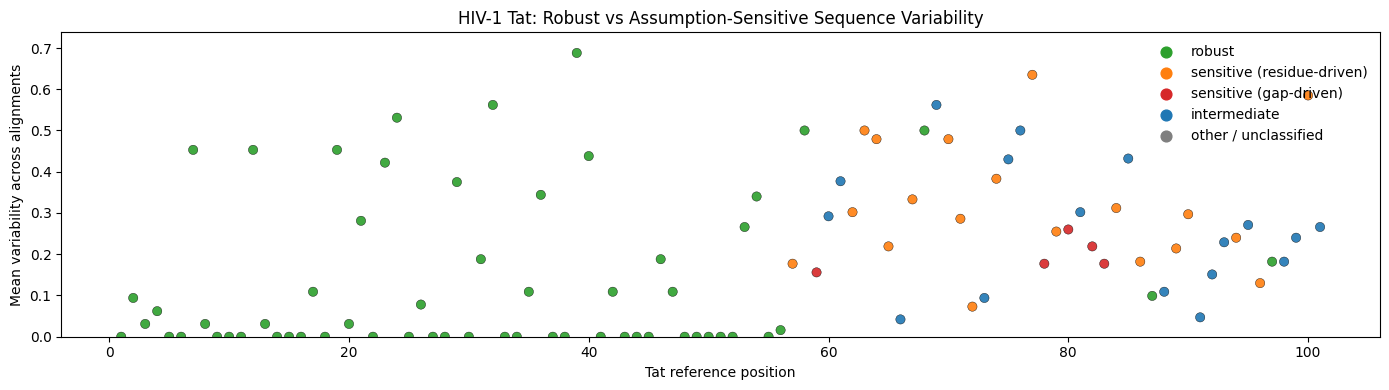

In [ ]:
plot_df = view_mapped.dropna(subset=["ref_pos","class"]).copy()
plot_df["ref_pos"] = plot_df["ref_pos"].astype(int)

color_map = {
    "robust": "#2ca02c",
    "sensitive (residue-driven)": "#ff7f0e",
    "sensitive (gap-driven)": "#d62728",
    "intermediate (residue-driven)": "#1f77b4",
    "intermediate (gap-driven)": "#1f77b4",
}

plot_df["color"] = plot_df["class"].apply(lambda x: color_map.get(x, "#7f7f7f"))

plt.figure(figsize=(14,4))
plt.scatter(
    plot_df["ref_pos"],
    plot_df["mean_var"],
    c=plot_df["color"].tolist(),
    s=45,
    alpha=0.9,
    edgecolor="black",
    linewidth=0.3
)
plt.xlabel("Tat reference position")
plt.ylabel("Mean variability across alignments")
plt.title("HIV-1 Tat: Robust vs Assumption-Sensitive Sequence Variability")

# legend
for label, color in {k:v for k,v in color_map.items() if "intermediate" not in k}.items():
    plt.scatter([], [], c=color, label=label, s=60)
plt.scatter([], [], c=color_map["intermediate (residue-driven)"], label="intermediate", s=60)
plt.scatter([], [], c="#7f7f7f", label="other / unclassified", s=60)

plt.legend(frameon=False, loc="upper right")
plt.ylim(0, plot_df["mean_var"].max() + 0.05)
plt.tight_layout()
plt.show()

## 9. Results (methodological)

Across HIV-1 Tat, many positions exhibit variability that is stable across multiple reasonable alignment assumptions (robust variability). A smaller subset of positions - particularly toward the C-terminus - shows strong assumption sensitivity, including rare gap-driven artifacts and residue-driven variability whose magnitude depends on alignment choices. This highlights that alignment is not neutral preprocessing and should be treated as an explicit modeling assumption when interpreting per-position variability.

## Limitations

This notebook does not infer biological function or selection mechanisms. Sensitivity is assessed relative to a chosen set of alignment parameters; broader parameter grids and alternative aligners could extend the robustness assessment.